# Emerging Cluster Model

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import requests, bs4

In [2]:
current_path = os.getcwd()

In [3]:
data_set = pd.read_csv(current_path + "\\Dataset\\precision_agriculture_patents.csv", low_memory=False) 

In [4]:
data_set.columns

Index(['Publication_Number', 'Publication_Year', 'Title', 'Applicants',
       'IPCR_Classifications', 'Main_Class', 'Main_Subclass', 'Abstract',
       'Claims_count', 'Citation_count', 'Citation_ids', 'Citation_dates',
       'Cited_count', 'Cited_ids', 'Cited_dates'],
      dtype='object')

In [5]:
df = data_set[['Publication_Number','Publication_Year', 'Cited_count','Cited_dates', 'Cited_ids']]

In [6]:
year_threshold = 2010

In [7]:
df = df[df['Cited_count'] != 0]
df = df[df['Publication_Year'] > year_threshold]
df = df.reset_index(drop=True)

In [8]:
df.head()

,Publication_Number,Publication_Year,Cited_count,Cited_dates,Cited_ids
0,US 2015/0302305 A1,2015,16,2014-06-18;;2014-08-29;;2014-09-30;;2015-02-06...,US20160063415A1;;US20160065532A1;;US2016009312...
1,US 2018/0014452 A1,2018,5,2015-03-13;;2016-11-16;;2015-08-05;;2016-12-30...,US20160267203A1;;US10028451B2;;US10139797B2;;U...
2,US 2016/0302351 A1,2016,10,2014-11-27;;2016-07-06;;2015-04-20;;2015-03-30...,US20160150744A1;;US9563848B1;;US20170041407A1;...
3,US 2013/0185104 A1,2013,22,2011-06-30;;2012-10-30;;2012-10-29;;2013-03-15...,US20130006401A1;;US20140122175A1;;US2014012248...
4,US 2017/0015416 A1,2017,6,2015-07-20;;2015-07-17;;2017-05-01;;2017-08-08...,US20170025744A1;;US20170334560A1;;WO2018203973...


In [9]:
series = df.Cited_count.sort_values(ascending=True)

In [10]:
values = pd.Series(series.values)

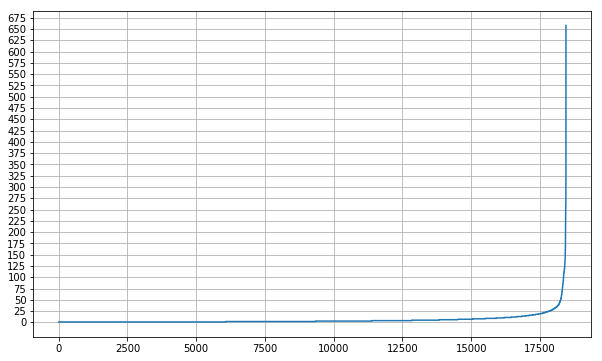

In [11]:
plt.yticks(range(0,series.max() + 100, 25))
values.plot(figsize=(10, 6))
plt.grid()

In [12]:
df_citation = df.copy()
df_citation = df_citation.loc[df_citation["Cited_count"] >= 35].reset_index(drop=True)

In [13]:
def updateDictionary(dictionary, key):
    if key not in dictionary:
        dictionary[key] = 1
    else: dictionary[key]+=1

In [14]:
ending_year = 2020
for year in range(year_threshold,ending_year):
    df_citation[str(year)]=0

In [15]:
for idx in range(len(df_citation)):
    dates_cited = df_citation.at[idx,"Cited_dates"].split(';;')
    years = {}
    for date in dates_cited:
        updateDictionary(years,date[:4])
    for k,v in years.items():
        if int(k) >= df_citation.at[idx, 'Publication_Year']: 
            df_citation.at[idx,k] = int(v)

In [16]:
df_citation["2010-2011"] = 0
df_citation["2011-2012"] = 0
df_citation["2012-2013"] = 0
df_citation["2013-2014"] = 0
df_citation["2014-2015"] = 0
df_citation["2015-2016"] = 0
df_citation["2016-2017"] = 0
df_citation["2017-2018"] = 0
df_citation["2018-2019"] = 0

for idx in range(len(df_citation)):
    df_citation.at[idx,"2010-2011"] = df_citation.at[idx, "2010"] + df_citation.at[idx, "2011"]
    df_citation.at[idx,"2011-2012"] = df_citation.at[idx, "2011"] + df_citation.at[idx, "2012"]
    df_citation.at[idx,"2012-2013"] = df_citation.at[idx, "2012"] + df_citation.at[idx, "2013"]
    df_citation.at[idx,"2013-2014"] = df_citation.at[idx, "2013"] + df_citation.at[idx, "2014"]
    df_citation.at[idx,"2014-2015"] = df_citation.at[idx, "2014"] + df_citation.at[idx, "2015"]
    df_citation.at[idx,"2015-2016"] = df_citation.at[idx, "2015"] + df_citation.at[idx, "2016"]
    df_citation.at[idx,"2016-2017"] = df_citation.at[idx, "2016"] + df_citation.at[idx, "2017"]
    df_citation.at[idx,"2017-2018"] = df_citation.at[idx, "2017"] + df_citation.at[idx, "2018"]
    df_citation.at[idx,"2018-2019"] = df_citation.at[idx, "2018"] + df_citation.at[idx, "2019"]
    

#### Check if a patent is higly cited and has an high percentage (percentage > cutoff)

In [17]:
df_citation["ishot_2011"] = 0
df_citation["ishot_2012"] = 0
df_citation["ishot_2013"] = 0
df_citation["ishot_2014"] = 0
df_citation["ishot_2015"] = 0
df_citation["ishot_2016"] = 0
df_citation["ishot_2017"] = 0
df_citation["ishot_2018"] = 0
df_citation["ishot_2019"] = 0

In [18]:
def get_rank(citation_occ):
    s = pd.Series(citation_occ).sort_values(ascending=False)
    # Cut off the zero values
    if 0 in s.values:
        series_index = s[s == 0].index[0]
        effective_index = s.index.get_loc(series_index)
        s = s[:effective_index]

    # Compute the top10% rank
    index_ten_per_cent = int(len(s)*10/100)
    s = s[:(index_ten_per_cent)]
    list_patents = []
    for index, val in s.iteritems():
        list_patents.append(df_citation.at[index, "Publication_Number"])
    return list_patents

In [19]:
first = 2010
end = 2019

for i in range(first, end):
    second = first+1
    indice = str(first)+"-"+str(second)
    rank = get_rank(df_citation[indice])
    for idx in range(len(df_citation)):
        citation_received = df_citation.at[idx,indice]
        publication_number = df_citation.at[idx,"Publication_Number"]
        percentage = citation_received / df_citation.at[idx,"Cited_count"]
        cutoff = (-1/80) * (2019-int(df_citation.at[idx,"Publication_Year"])) + (5/8)   
        if(publication_number in rank and percentage > cutoff):
            field = "ishot_"+str(second)
            df_citation.at[idx,field] = 1  
    
    first = first + 1

#### Selection of hot patents

In [20]:
df_citation["ishot"] = 0
for idx in range(len(df_citation)):
    somma = 0 
    for year in range(year_threshold+1,2020):
        somma = somma + df_citation.at[idx,"ishot_"+str(year)]
        year = year + 1
    if somma > 0:
        df_citation.at[idx,"ishot"] = 1

In [21]:
df_citation.ishot.value_counts()

0    312
1     27
Name: ishot, dtype: int64

In [22]:
df_hot_patents = df_citation
df_hot_patents = df_hot_patents[df_hot_patents['ishot'] != 0]

#### Create df with hot patents, assigning "hot patent year" 

In [23]:
df_next_generation = pd.DataFrame()

In [24]:
for year in range(year_threshold+1,2020):
    df_aux = df_hot_patents.loc[df_hot_patents["ishot_"+str(year)] == 1]
    df_aux["ishotin"] = year
    df_next_generation = df_next_generation.append(df_aux, sort=False)
    year = year + 1

C:\Users\Antonio\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
df_next_generation = df_next_generation.reset_index(drop=True)
df_next_generation['next_generation'] = ""
for idx in range(len(df_next_generation)):
    dates = df_next_generation.loc[idx].Cited_dates.split(';;')
    patents_id  = df_next_generation.loc[idx].Cited_ids.split(';;')
    
    years = []
    for elem in dates:
        years.append(elem[:4])
    
    next_generation = []
    hot_in_year = df_next_generation.at[idx,'ishotin']
    for i in range(len(years)):
        if years[i]== str(hot_in_year) or years[i]==str(hot_in_year - 1):
            next_generation.append(patents_id[i])
    df_next_generation.at[idx,'next_generation'] = next_generation

In [26]:
df_next_generation.head(3)

,Publication_Number,Publication_Year,Cited_count,Cited_dates,Cited_ids,2010,2011,2012,2013,2014,...,ishot_2013,ishot_2014,ishot_2015,ishot_2016,ishot_2017,ishot_2018,ishot_2019,ishot,ishotin,next_generation
0,US 2011/0318717 A1,2011,123,2010-11-05;;2011-01-14;;2011-03-08;;2011-03-08...,US20120116563A1;;US20120183932A1;;US2012023300...,0,39,31,20,13,...,0,0,0,0,0,0,0,1,2012,"[US20120183932A1, US20120233002A1, US201202330..."
1,WO 2011/066384 A1,2011,153,2010-12-01;;2010-11-29;;2010-12-01;;2011-01-07...,WO2012072660A1;;WO2012072489A1;;WO2012072696A1...,0,30,61,16,4,...,0,0,0,0,0,0,0,1,2012,"[US20120178627A1, WO2012120105A1, WO2012126938..."
2,US 2011/0139658 A1,2011,53,2012-05-31;;2012-05-31;;2012-06-29;;2012-06-29...,WO2013180913A1;;WO2013180912A1;;WO2014004940A1...,0,4,21,15,7,...,1,0,0,0,0,0,0,1,2013,"[WO2013180913A1, WO2013180912A1, WO2014004940A..."


##### In next_generation we have the list of publication_id to download with the crawler

###### We suggest to skip the next 9 slots in order to do not launch the crawler again, and load the dataframe with the existing file

In [30]:
next_gen_patents = []
for idx in range(len(df_next_generation)):
    for id_pat in df_next_generation.at[idx,"next_generation"]:
        next_gen_patents.append(id_pat)

In [31]:
def getting_data_from_patent(id_num, link):
    not_found_abstract = 0
    try:
        response = requests.get(link)
    except:
        print("Error URL with: " + link)
        return -1
    
    if(response.status_code == 404):
        print("Status 404: " + link)
        return 404
    
    patentSoup = bs4.BeautifulSoup(response.text)

    try:        
        abstract = patentSoup.find(name="abstract").text
    except:
        abstract = ""
        print("Status 300: " + link)
        return 300

    abstract = abstract[1:]
    
    try:
        title = patentSoup.find("span", itemprop="title").text
    except:
        title = ""
        print("Status 301: " + link)        
        return 301
        
    try:
        classification = patentSoup.find_all("span", itemprop="Code")
    except:
        print("Status 302: " + link)        
        return 302
    
    if len(classification) > 0:
        code_list = []
        for code in classification:
            if(len(code.text)>4):
                code_list.append(code.text)
        code_list=list(set(code_list))
    else: code_list = []
    
    return id_num, title, abstract, code_list

In [32]:
attributes = ['Publication_Number', 'Title', 'Abstract', 'Classification']
data_crawler =  pd.DataFrame(columns = attributes)

In [37]:
patent_num = 1 
total_patents = (len(next_gen_patents))
not_found = 0
not_found_abstract = 0
not_found_title = 0
not_found_class = 0 
for id_num in next_gen_patents:
    row = tuple()
    print ("Patent " + str(patent_num) + " of " + str(total_patents))

    url = "https://patents.google.com/patent/" + id_num
    
    row = getting_data_from_patent(id_num, url)
    if row == -1:
        break
    if row == 404:
        not_found = not_found + 1
    elif row == 300:
        not_found_abstract = not_found_abstract + 1
    elif row == 301:
        not_found_title = not_found_title + 1        
    elif row == 302:
        not_found_class = not_found_class + 1          
    else: 
        data_crawler = data_crawler.append(pd.Series(row, index=data_crawler.columns ), ignore_index=True)

    patent_num = patent_num + 1

Patent 1 of 1811
Patent 2 of 1811
Patent 3 of 1811
Patent 4 of 1811
Patent 5 of 1811
Patent 6 of 1811
Patent 7 of 1811
Patent 8 of 1811
Patent 9 of 1811
Patent 10 of 1811
Patent 11 of 1811
Patent 12 of 1811
Patent 13 of 1811
Patent 14 of 1811
Patent 15 of 1811
Patent 16 of 1811
Patent 17 of 1811
Patent 18 of 1811
Patent 19 of 1811
Patent 20 of 1811
Patent 21 of 1811
Patent 22 of 1811
Patent 23 of 1811
Patent 24 of 1811
Patent 25 of 1811
Patent 26 of 1811
Patent 27 of 1811
Patent 28 of 1811
Patent 29 of 1811
Patent 30 of 1811
Patent 31 of 1811
Patent 32 of 1811
Patent 33 of 1811
Patent 34 of 1811
Patent 35 of 1811
Patent 36 of 1811
Patent 37 of 1811
Patent 38 of 1811
Patent 39 of 1811
Patent 40 of 1811
Patent 41 of 1811
Patent 42 of 1811
Patent 43 of 1811
Patent 44 of 1811
Patent 45 of 1811
Patent 46 of 1811
Patent 47 of 1811
Patent 48 of 1811
Patent 49 of 1811
Patent 50 of 1811
Patent 51 of 1811
Patent 52 of 1811
Patent 53 of 1811
Patent 54 of 1811
Patent 55 of 1811
Patent 56 of 1811
P

Patent 438 of 1811
Patent 439 of 1811
Patent 440 of 1811
Patent 441 of 1811
Patent 442 of 1811
Patent 443 of 1811
Patent 444 of 1811
Patent 445 of 1811
Patent 446 of 1811
Patent 447 of 1811
Patent 448 of 1811
Patent 449 of 1811
Patent 450 of 1811
Patent 451 of 1811
Patent 452 of 1811
Patent 453 of 1811
Patent 454 of 1811
Patent 455 of 1811
Patent 456 of 1811
Patent 457 of 1811
Patent 458 of 1811
Patent 459 of 1811
Patent 460 of 1811
Patent 461 of 1811
Patent 462 of 1811
Patent 463 of 1811
Patent 464 of 1811
Patent 465 of 1811
Patent 466 of 1811
Patent 467 of 1811
Patent 468 of 1811
Patent 469 of 1811
Patent 470 of 1811
Patent 471 of 1811
Patent 472 of 1811
Patent 473 of 1811
Patent 474 of 1811
Patent 475 of 1811
Patent 476 of 1811
Patent 477 of 1811
Patent 478 of 1811
Patent 479 of 1811
Patent 480 of 1811
Patent 481 of 1811
Patent 482 of 1811
Patent 483 of 1811
Patent 484 of 1811
Patent 485 of 1811
Patent 486 of 1811
Patent 487 of 1811
Patent 488 of 1811
Patent 489 of 1811
Patent 490 o

Patent 848 of 1811
Patent 849 of 1811
Patent 850 of 1811
Patent 851 of 1811
Patent 852 of 1811
Patent 853 of 1811
Patent 854 of 1811
Patent 855 of 1811
Patent 856 of 1811
Patent 857 of 1811
Patent 858 of 1811
Patent 859 of 1811
Patent 860 of 1811
Patent 861 of 1811
Patent 862 of 1811
Patent 863 of 1811
Patent 864 of 1811
Patent 865 of 1811
Patent 866 of 1811
Patent 867 of 1811
Patent 868 of 1811
Patent 869 of 1811
Patent 870 of 1811
Patent 871 of 1811
Patent 872 of 1811
Patent 873 of 1811
Patent 874 of 1811
Patent 875 of 1811
Patent 876 of 1811
Patent 877 of 1811
Patent 878 of 1811
Patent 879 of 1811
Patent 880 of 1811
Patent 881 of 1811
Patent 882 of 1811
Patent 883 of 1811
Patent 884 of 1811
Patent 885 of 1811
Patent 886 of 1811
Patent 887 of 1811
Patent 888 of 1811
Patent 889 of 1811
Patent 890 of 1811
Patent 891 of 1811
Patent 892 of 1811
Patent 893 of 1811
Patent 894 of 1811
Patent 895 of 1811
Patent 896 of 1811
Patent 897 of 1811
Patent 898 of 1811
Patent 899 of 1811
Patent 900 o

Patent 1248 of 1811
Patent 1249 of 1811
Patent 1250 of 1811
Patent 1251 of 1811
Patent 1252 of 1811
Patent 1253 of 1811
Patent 1254 of 1811
Patent 1255 of 1811
Patent 1256 of 1811
Patent 1257 of 1811
Patent 1258 of 1811
Patent 1259 of 1811
Patent 1260 of 1811
Patent 1261 of 1811
Patent 1262 of 1811
Patent 1263 of 1811
Patent 1264 of 1811
Patent 1265 of 1811
Patent 1266 of 1811
Patent 1267 of 1811
Patent 1268 of 1811
Patent 1269 of 1811
Patent 1270 of 1811
Patent 1271 of 1811
Patent 1272 of 1811
Patent 1273 of 1811
Patent 1274 of 1811
Patent 1275 of 1811
Patent 1276 of 1811
Patent 1277 of 1811
Patent 1278 of 1811
Patent 1279 of 1811
Patent 1280 of 1811
Patent 1281 of 1811
Patent 1282 of 1811
Patent 1283 of 1811
Patent 1284 of 1811
Patent 1285 of 1811
Patent 1286 of 1811
Patent 1287 of 1811
Patent 1288 of 1811
Patent 1289 of 1811
Patent 1290 of 1811
Patent 1291 of 1811
Patent 1292 of 1811
Patent 1293 of 1811
Patent 1294 of 1811
Patent 1295 of 1811
Patent 1296 of 1811
Patent 1297 of 1811


Patent 1652 of 1811
Patent 1653 of 1811
Patent 1654 of 1811
Patent 1655 of 1811
Patent 1656 of 1811
Patent 1657 of 1811
Patent 1658 of 1811
Patent 1659 of 1811
Patent 1660 of 1811
Patent 1661 of 1811
Patent 1662 of 1811
Patent 1663 of 1811
Patent 1664 of 1811
Patent 1665 of 1811
Patent 1666 of 1811
Patent 1667 of 1811
Patent 1668 of 1811
Patent 1669 of 1811
Patent 1670 of 1811
Patent 1671 of 1811
Patent 1672 of 1811
Patent 1673 of 1811
Patent 1674 of 1811
Patent 1675 of 1811
Patent 1676 of 1811
Patent 1677 of 1811
Patent 1678 of 1811
Patent 1679 of 1811
Patent 1680 of 1811
Patent 1681 of 1811
Patent 1682 of 1811
Patent 1683 of 1811
Patent 1684 of 1811
Patent 1685 of 1811
Patent 1686 of 1811
Patent 1687 of 1811
Patent 1688 of 1811
Patent 1689 of 1811
Patent 1690 of 1811
Patent 1691 of 1811
Patent 1692 of 1811
Patent 1693 of 1811
Patent 1694 of 1811
Patent 1695 of 1811
Patent 1696 of 1811
Patent 1697 of 1811
Patent 1698 of 1811
Patent 1699 of 1811
Patent 1700 of 1811
Patent 1701 of 1811


In [38]:
not_found

0

In [39]:
not_found_title

0

In [40]:
not_found_abstract

15

In [41]:
not_found_class

0

In [ ]:
data_crawler.to_csv(current_path+"\\Dataset\\next_generation_patents.csv", index=False)

##### Get next generation patents from the file

In [27]:
data_crawler = pd.read_csv(current_path+"\\Dataset\\next_generation_patents.csv")

In [28]:
for idx in range(len(data_crawler)):
    x = data_crawler.loc[idx,"Classification"]
    x = x.replace("[","")
    x = x.replace("]","")
    x = x.replace("'","")
    x = x.replace(", ",";;")
    data_crawler.loc[idx,"Classification"] = x

#### Assigne class and subclass

In [29]:
data_crawler = data_crawler.drop_duplicates(subset ="Publication_Number", keep = "last") 
data_crawler = data_crawler.reset_index(drop=True)

In [30]:
def assigne_class_subclass(Ipcr_class):
    ipcr_values = Ipcr_class.split(';;')
    class_values= []
    subclass_values = []
    for ipcr in ipcr_values:
        class_values.append(ipcr[:3])
        subclass_values.append(ipcr[:4])
        
    return max(class_values,key=class_values.count), max(subclass_values,key=subclass_values.count)

In [31]:
data_crawler['Main_Class'] = ""
data_crawler['Main_Subclass'] = ""
for i in range(len(data_crawler)):
    classe, sottoclasse = assigne_class_subclass(data_crawler.at[i,"Classification"])
    data_crawler.loc[i,"Main_Class"] = classe
    data_crawler.loc[i,"Main_Subclass"] = sottoclasse

In [32]:
data_crawler.head(3)

,Publication_Number,Title,Abstract,Classification,Main_Class,Main_Subclass
0,US20120178627A1,Increased tolerance of dht-enabled plants to a...,The present invention relates to a method of c...,A01N39/04;;A01N39/00;;A01N39/02,A01,A01N
1,WO2012120105A1,Use of lipochito-oligosaccharide compounds for...,The present invention relates to the use of li...,A01N43/16;;A01N43/00;;A01N43/14;;A01N43/02;;A0...,A01,A01N
2,WO2012126938A2,Active compound combinations \r\n,The present invention relates to active compou...,A01N43/40;;Y02A90/22;;A01N43/34;;A01N37/22;;A0...,A01,A01N


In [33]:
data_crawler = data_crawler.dropna(subset=['Main_Class'])

In [34]:
len(data_crawler)

1219

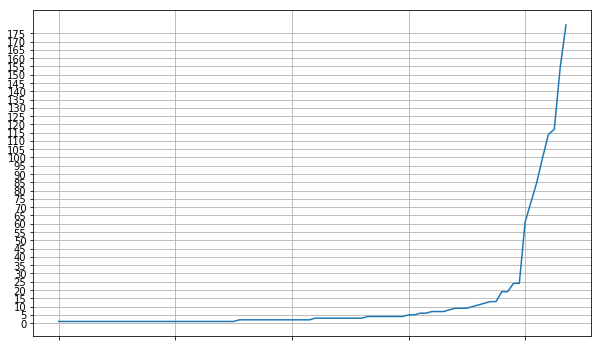

In [35]:
s = data_crawler.Main_Subclass.value_counts().sort_values(ascending=True)
plt.yticks(range(0,max(s),5))
s.plot(figsize=(10, 6))
plt.grid()

#### We set the threshold to 25 anbd we select the subclasses with a value under the threshold

In [36]:
for k,v in data_crawler.Main_Subclass.value_counts().items():
    print(k,v)

H04L 180
C07D 154
A01N 117
G06F 114
G06Q 100
C12N 85
H02J 73
C11D 61
H05B 24
B64C 24
A61M 19
A61F 19
H04W 13
H04N 13
Y02A 12
A24F 11
G06T 10
G06K 9
H01Q 9
G01S 9
A61B 8
G01N 7
A23K 7
C07C 7
C07F 6
B65H 6
C07K 5
A24B 5
G05B 4
G05D 4
H02M 4
G16H 4
B65D 4
H01M 4
A47J 4
G08G 3
A23B 3
G07F 3
A01K 3
A63B 3
G07C 3
G01G 3
B32B 3
A47K 3
H04M 2
B26D 2
G09B 2
A23P 2
G09G 2
B60K 2
H04B 2
G01J 2
G02B 2
G08C 2
G01C 2
B60L 2
A61K 2
B64D 1
G06N 1
A63F 1
A01B 1
H03K 1
B65G 1
A61P 1
A01M 1
D04H 1
A61C 1
B29C 1
Y02T 1
C40B 1
C12Q 1
A01G 1
C12P 1
A01D 1
Y02P 1
G01F 1
G01R 1
H01G 1
B67D 1
B60W 1
C05G 1
C12Y 1
B23P 1
A23L 1
H01F 1
B05C 1
B65B 1
G08B 1


In [37]:
selected_subclasses_ngp = ["B64C","A61F","A61M","H04W","H04N","Y02A","A24F","G06T","G06K","H01Q","G01S","A61B","G01N","A23K","C07C","B65H","C07F","A24B","C07K","G16H","B65D","H01M","G05B","G05D","A47J","H02M","G07F","A47K","G07C","G01G","B32B","A01K","A23B","A63B","G08G","G09G","G08C","H04B","B60K","G09B","A61K","G01C","H04M","B26D","A23P","B60L","G01J","G02B","A23L","A01B","A63F","B29C","D04H","H01F","A61C","A01D","G01F","B60W","G06N","C40B","C12Y","B23P","B67D","A61P","B65B","H03K","Y02P","Y02T","C12Q","C05G","G01R","A01G","A01M","B05C","G08B","B65G","B64D","H01G","C12P"]

In [38]:
emerging_subclasses_rq1a  = ['A01B','A01D','G06T','H04W','A01K','G06K','G01S','A01M','G05B','H04L','G01C','G05D','H05B','G06N','C05G','G16B']

In [39]:
selected_subclasses = list(set(selected_subclasses_ngp + emerging_subclasses_rq1a))

In [46]:
print(selected_subclasses)

['B64C', 'B60W', 'H01M', 'C07F', 'C40B', 'B05C', 'Y02A', 'H04M', 'B65D', 'G05D', 'G16H', 'G01F', 'A24F', 'B67D', 'A61M', 'B29C', 'G01R', 'G01S', 'H04W', 'G08G', 'B65B', 'H01Q', 'B65G', 'A63F', 'D04H', 'G09B', 'B26D', 'G06K', 'C12Y', 'G06T', 'G01J', 'H04B', 'C07C', 'A61F', 'H04N', 'A23B', 'H01G', 'H05B', 'B23P', 'A63B', 'A23P', 'C05G', 'H01F', 'G07C', 'H04L', 'B60L', 'G05B', 'Y02P', 'G16B', 'A24B', 'G07F', 'G06N', 'G08B', 'A47J', 'G01C', 'G09G', 'H02M', 'H03K', 'Y02T', 'B65H', 'G02B', 'A23L', 'B32B', 'G01G', 'A01M', 'A47K', 'G08C', 'A61P', 'B64D', 'B60K', 'A01K', 'A61C']


#### we remove from the selected subclasses those classified as affirmed one in RQ1 A

In [47]:
affirmed_subclasses_rq1a = ['C12N','A61K','G01N','A01H','A01N','C07K','C12P','G06Q','C12Q','A01C','G06F','A01G','A01B','C02F','A01D','C07D','A61B','B05B','A23K','B62D','A01F','C12N','G01N','A01N','C12Q','A01C','G06F','A01G','A01B','C02F','A01D','A61B','B05B','H02J','H01L','G06F','A61B']

In [48]:
selected_subclasses = [x for x in selected_subclasses if x not in affirmed_subclasses_rq1a]

In [49]:
print(selected_subclasses)

['B64C', 'B60W', 'H01M', 'C07F', 'C40B', 'B05C', 'Y02A', 'H04M', 'B65D', 'G05D', 'G16H', 'G01F', 'A24F', 'B67D', 'A61M', 'B29C', 'G01R', 'G01S', 'H04W', 'G08G', 'B65B', 'H01Q', 'B65G', 'A63F', 'D04H', 'G09B', 'B26D', 'G06K', 'C12Y', 'G06T', 'G01J', 'H04B', 'C07C', 'A61F', 'H04N', 'A23B', 'H01G', 'H05B', 'B23P', 'A63B', 'A23P', 'C05G', 'H01F', 'G07C', 'H04L', 'B60L', 'G05B', 'Y02P', 'G16B', 'A24B', 'G07F', 'G06N', 'G08B', 'A47J', 'G01C', 'G09G', 'H02M', 'H03K', 'Y02T', 'B65H', 'G02B', 'A23L', 'B32B', 'G01G', 'A01M', 'A47K', 'G08C', 'A61P', 'B64D', 'B60K', 'A01K', 'A61C']


#### After a manually extraction with Lens Classification Explorer we obtained the following subclasses

In [53]:
emerging_subclasses = ['B64C','H04N','G08G','Y02A','Y02P','G16H','A01B','A01D','G01S','G05B','G06T','H04L','G01C','H04W','A01K','G06K','A01M','G05D','H05B','G06N','C05G','G16B']

In [54]:
print(emerging_subclasses)

['B64C', 'H04N', 'G08G', 'Y02A', 'Y02P', 'G16H', 'A01B', 'A01D', 'G01S', 'G05B', 'G06T', 'H04L', 'G01C', 'H04W', 'A01K', 'G06K', 'A01M', 'G05D', 'H05B', 'G06N', 'C05G', 'G16B']


In [55]:
f = open(current_path + "\\OutputFiles\\List of emerging sectors.txt", "w")
for sc in emerging_subclasses:
    f.write(sc +'\n')
f.close()

#### Extraction of groups

In [58]:
ipc_group_code_list = []
for idx in range(len(data_crawler)):
    ipc_code = data_crawler.loc[idx,"Classification"].split(";;")
    for ipc in ipc_code:
        ipc_group_code_list.append(ipc.split('/')[0])
        
ipc_group_code_list = list(set(ipc_group_code_list))

In [59]:
selected_group = []
for group in ipc_group_code_list:
    if group[0:4] in emerging_subclasses:
        selected_group.append(group)

In [60]:
print(ipc_group_code_list)

['C07C57', 'B60L2260', 'C40B50', 'G06Q50', 'Y02P60', 'B60R11', 'H04L67', 'E02D1', 'C07D333', 'G01J2003', 'B60K2350', 'G01M99', 'B65H45', 'G01N29', 'A61M15', 'C12N7', 'B26F1', 'B65D75', 'G01S5', 'B64F3', 'B65B61', 'B65B2230', 'A63B43', 'C07D513', 'B60L11', 'C07D307', 'B65H27', 'C07D317', 'C07D473', 'H04B7', 'B64C39', 'B65B11', 'G16C99', 'H02J2207', 'C07K14', 'C11D3', 'B82Y5', 'D01F6', 'Y10T83', 'B65B29', 'A61M2209', 'G06Q30', 'A63B2243', 'G01N2201', 'A61B5', 'B31F1', 'G16H40', 'A01D29', 'C07D491', 'C07C239', 'G16C20', 'G01S1', 'A01D41', 'B26D1', 'C07D413', 'G07C2209', 'C07C211', 'G10K11', 'C07D519', 'A63F13', 'A61K2800', 'A01M7', 'H01Q13', 'H05B3', 'C12N2740', 'D06M16', 'A61C9', 'A47L2601', 'A61C5', 'Y02P90', 'A63B71', 'B26D5', 'A01N45', 'B29C33', 'G11B27', 'G06F2209', 'A24F47', 'Y02P20', 'C12N2320', 'H04B17', 'B26D7', 'H04N21', 'B65H2404', 'C11B9', 'C07D249', 'A01K2207', 'F04C2270', 'B65H2301', 'B65B2220', 'F23Q2007', 'B64C29', 'C07D263', 'C07C33', 'B62D5', 'B23K26', 'G07F17', 'G01C11'

#### Analysis with Lens Classification Explorer